# LSTM model for prediction in weather and prices

## Part 1: Data Analysis and new variables construction

In [1]:
# importing libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

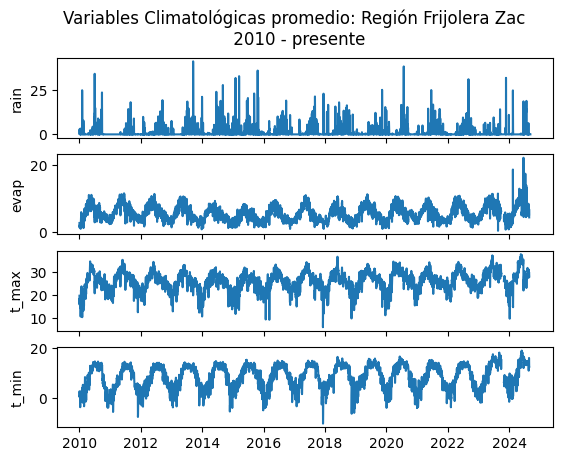

In [2]:
# Data Collection

bayo_prices = pd.read_csv('prices_data/bayo_clean_data.csv',index_col='date')
bayo_prices.index = pd.to_datetime(bayo_prices.index)

weather_zac = pd.read_csv('weather_data/zac_region_frij.csv',index_col='date')
weather_zac.index = pd.to_datetime(weather_zac.index)
weather_zac.drop(columns=['year','month'], inplace=True)

f, ax = plt.subplots(4,1, sharex=True)
for i in range(4):
    ax[i].plot(weather_zac.loc['2010-01-01':].index.values,
                weather_zac[weather_zac.columns[i]].loc['2010-01-01':].values)
    ax[i].set_ylabel(weather_zac.columns[i])

a1 = f.suptitle('Variables Climatológicas promedio: Región Frijolera Zac \n 2010 - presente')

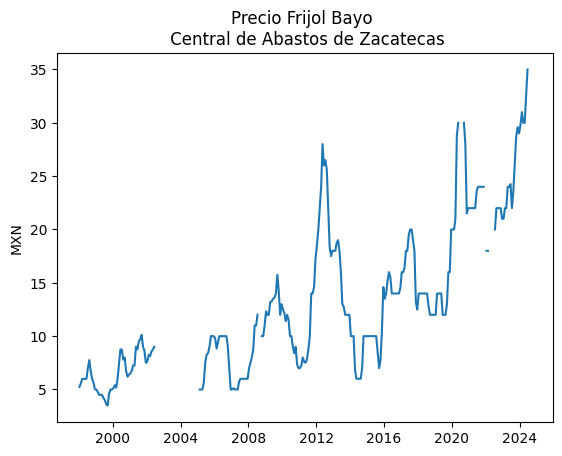

In [3]:
f, ax = plt.subplots()
ax.plot(bayo_prices.index, bayo_prices.values)
ax.set_ylabel('MXN')
a2 = ax.set_title('Precio Frijol Bayo \n Central de Abastos de Zacatecas')

In [4]:
# to know the inital time of measures of prices of bean : 1998-01-15
bayo_prices.head()

,price
date,
1998-01-15,5.25
1998-02-15,5.58
1998-03-15,6.00
1998-04-15,6.00
1998-05-15,6.00


In [5]:
bayo_data = weather_zac.loc['1998-01-15':].join(bayo_prices)
bayo_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9726 entries, 1998-01-15 to 2024-09-12
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rain    9725 non-null   float64
 1   evap    9688 non-null   float64
 2   t_max   9695 non-null   float64
 3   t_min   9695 non-null   float64
 4   price   278 non-null    float64
dtypes: float64(5)
memory usage: 455.9 KB


In [6]:
bayo_data.tail(20)

,rain,evap,t_max,t_min,price
date,,,,,
2024-08-12,0.0000,6.892500,30.400000,14.500000,NaN
2024-08-13,0.0000,6.317500,30.060000,14.740000,NaN
2024-08-14,0.3200,8.227500,29.920000,14.440000,NaN
2024-08-15,0.0000,6.017500,29.900000,14.740000,30.0
2024-08-16,0.0000,7.447500,30.600000,14.300000,NaN
2024-08-17,0.0000,6.667500,30.120000,14.380000,NaN
2024-08-18,1.9020,7.452500,29.340000,13.300000,NaN
2024-08-19,6.3600,8.566667,30.140000,14.840000,NaN
2024-08-20,0.0000,5.337500,27.425000,14.900000,NaN


In [7]:
bayo_data.corr()

,rain,evap,t_max,t_min,price
rain,1.000000,-0.183338,-0.094161,0.325692,-0.003211
evap,-0.183338,1.000000,0.791835,0.384897,0.066848
t_max,-0.094161,0.791835,1.000000,0.644004,0.204855
t_min,0.325692,0.384897,0.644004,1.000000,0.143227
price,-0.003211,0.066848,0.204855,0.143227,1.000000


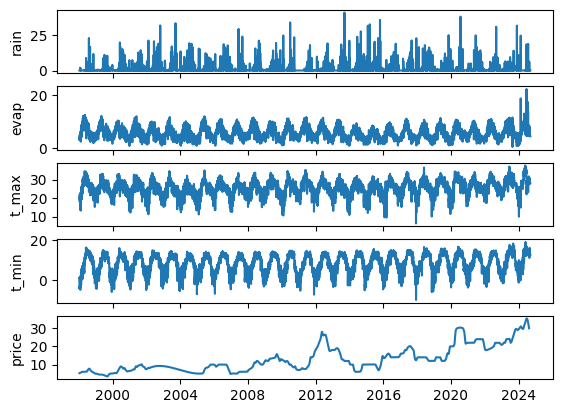

In [8]:
filled_data = bayo_data[['rain','evap','t_max','t_min']].interpolate(method='time')
filled_data['price']  = bayo_data['price'].interpolate(method='akima')

f, ax = plt.subplots(5,1, sharex=True)
for i in range(5):
    ax[i].plot(filled_data.index.values,
                filled_data[filled_data.columns[i]].values)
    ax[i].set_ylabel(filled_data.columns[i])

Al parecer no hay datos suficientes para predecir los precios del frijol

In [9]:
bayo_data.corr()

,rain,evap,t_max,t_min,price
rain,1.000000,-0.183338,-0.094161,0.325692,-0.003211
evap,-0.183338,1.000000,0.791835,0.384897,0.066848
t_max,-0.094161,0.791835,1.000000,0.644004,0.204855
t_min,0.325692,0.384897,0.644004,1.000000,0.143227
price,-0.003211,0.066848,0.204855,0.143227,1.000000


<Axes: >

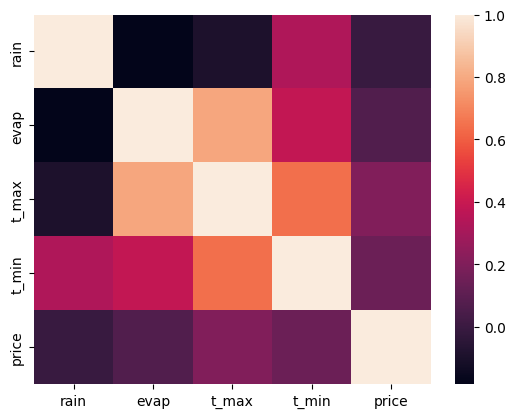

In [10]:
sns.heatmap(bayo_data.corr())

In [11]:
# historic_monthy_calcs = pd.DataFrame()
historic_data = bayo_data.copy()
historic_data['date'] = historic_data.index.values
historic_data['year'], historic_data['month'] = historic_data['date'].dt.year, historic_data['date'].dt.month
# grouping by months
historic_monthy_calcs1 = historic_data.groupby(['year','month'])[['rain','evap','t_max','t_min']].agg('mean')
historic_monthy_calcs2 = historic_data.groupby(['year','month'])[['rain','evap','t_max','t_min']].agg('sum')
historic_monthy_calcs3 = historic_data.groupby(['year','month'])[['rain','evap','t_max','t_min']].agg('std')


historic_monthy_calcs1.columns = [col+'_mean' for col in historic_monthy_calcs1.columns]
historic_monthy_calcs2.columns = [col+'_sum' for col in historic_monthy_calcs2.columns]
historic_monthy_calcs3.columns = [col+'_std' for col in historic_monthy_calcs3.columns]

historic_monthy_calcs = historic_monthy_calcs1.join([historic_monthy_calcs2, historic_monthy_calcs3])

historic_monthy_calcs.reset_index(level='month', inplace=True)
historic_monthy_calcs['year'] = historic_monthy_calcs.index.values.astype(str)
historic_monthy_calcs['date'] = historic_monthy_calcs['year'] + '-' + historic_monthy_calcs['month'].astype(str) + '-15'
historic_monthy_calcs['date'] = pd.to_datetime(historic_monthy_calcs['date'])

historic_monthy_calcs.drop(columns=['year','month'], inplace=True)
historic_monthy_calcs.set_index('date', inplace=True)
historic_monthy_calcs.head()

,rain_mean,evap_mean,t_max_mean,t_min_mean,rain_sum,evap_sum,t_max_sum,t_min_sum,rain_std,evap_std,t_max_std,t_min_std
date,,,,,,,,,,,,
1998-01-15,0.000025,4.170042,20.161520,-0.942892,0.000417,70.890714,342.745833,-16.029167,0.000101,0.634228,0.995767,1.628713
1998-02-15,0.145870,6.037474,20.814441,-0.332143,4.084348,169.049286,582.804348,-9.300000,0.452888,1.463992,3.094038,2.340046
1998-03-15,0.001438,7.880207,25.280108,3.254301,0.044583,244.286429,783.683333,100.883333,0.007622,1.422088,2.594261,2.102520
1998-04-15,0.015444,9.944881,28.874722,6.098889,0.463333,298.346429,866.241667,182.966667,0.084514,1.386838,1.391956,2.048647
1998-05-15,0.000029,10.597270,32.480352,10.318182,0.000909,328.515385,1006.890909,319.863636,0.000114,1.034250,1.050114,2.101651


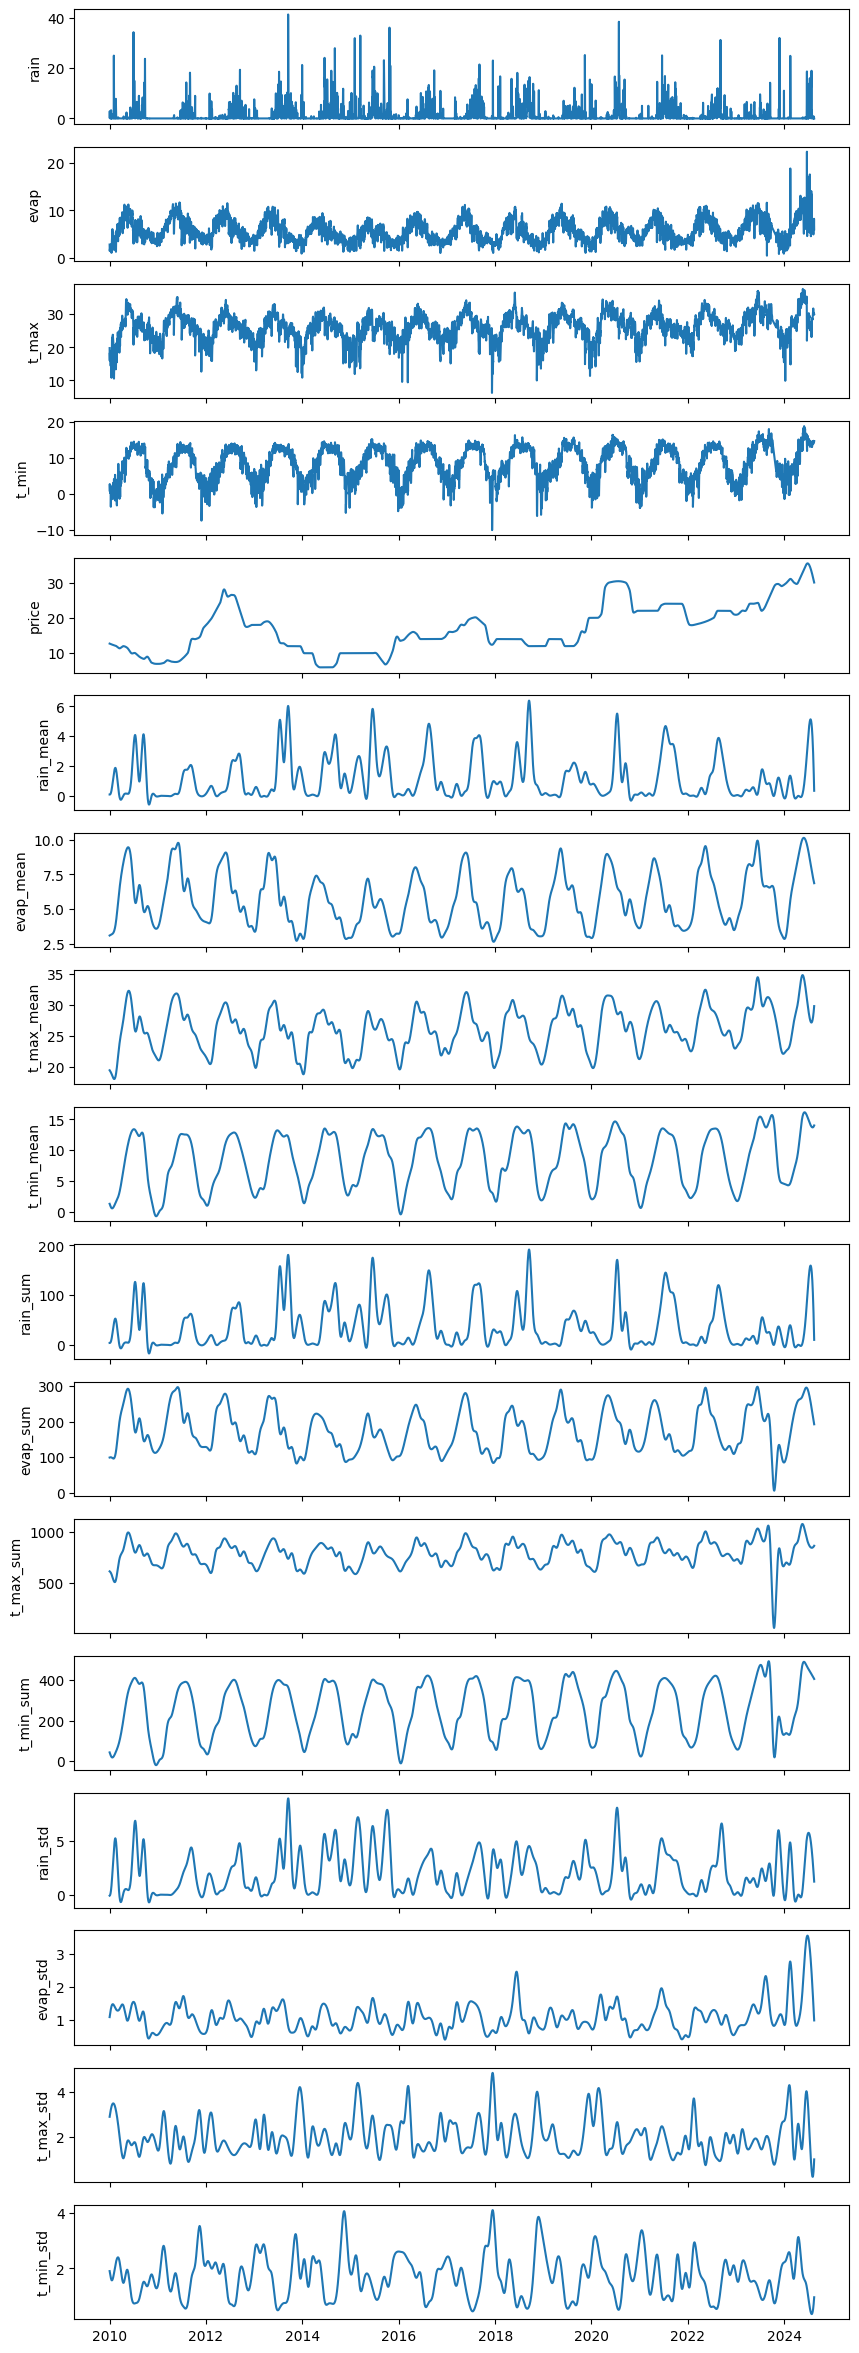

In [12]:
augmented_bayo_data = filled_data.join(historic_monthy_calcs)
augmented_bayo_data.tail(20)
augmented_bayo_data = augmented_bayo_data.loc[:'2024-08-15']

augmented_bayo_data = augmented_bayo_data.interpolate(method='cubic')

num_cols = len(augmented_bayo_data.columns)

f, ax = plt.subplots(num_cols,1, sharex=True, figsize = (10, 30))
for i in range(num_cols):
    ax[i].plot(augmented_bayo_data.loc['2010-01-01':].index.values,
                augmented_bayo_data[augmented_bayo_data.columns[i]].loc['2010-01-01':].values)
    ax[i].set_ylabel(augmented_bayo_data.columns[i])


In [13]:
price_corr = augmented_bayo_data.corr()['price']
price_corr

rain          0.002811
evap          0.084689
t_max         0.214671
t_min         0.176709
price         1.000000
rain_mean     0.011102
evap_mean     0.102129
t_max_mean    0.254383
t_min_mean    0.196474
rain_sum      0.012566
evap_sum      0.073104
t_max_sum     0.184603
t_min_sum     0.173353
rain_std      0.040058
evap_std      0.161700
t_max_std    -0.049434
t_min_std    -0.062367
Name: price, dtype: float64

<Axes: >

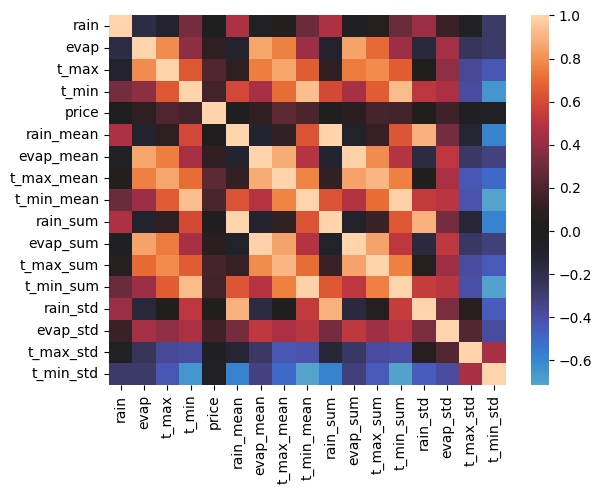

In [14]:
sns.heatmap(augmented_bayo_data.corr(), center=0)

In [15]:
augmented_bayo_data.tail()

,rain,evap,t_max,t_min,price,rain_mean,evap_mean,t_max_mean,t_min_mean,rain_sum,evap_sum,t_max_sum,t_min_sum,rain_std,evap_std,t_max_std,t_min_std
date,,,,,,,,,,,,,,,,,
2024-08-11,0.00,6.6900,30.25,14.583333,30.651047,1.764671,7.043386,28.811609,13.825560,54.692926,201.362786,855.865301,411.109678,1.958287,1.306599,0.546721,0.722463
2024-08-12,0.00,6.8925,30.40,14.500000,30.488859,1.437178,6.998767,29.030680,13.862911,44.393296,199.087928,857.622119,409.887383,1.778657,1.228989,0.640939,0.777023
2024-08-13,0.00,6.3175,30.06,14.740000,30.326204,1.091628,6.955184,29.264846,13.905217,33.519370,196.833813,859.498394,408.653719,1.595928,1.150926,0.748922,0.836045
2024-08-14,0.32,8.2275,29.92,14.440000,30.163209,0.727662,6.912679,29.514393,13.952603,22.059699,194.602580,861.493944,407.408255,1.410175,1.072461,0.871099,0.899637
2024-08-15,0.00,6.0175,29.90,14.740000,30.000000,0.344925,6.871299,29.779606,14.005192,10.002833,192.396369,863.608586,406.150556,1.221473,0.993643,1.007897,0.967909


## Part 2: Data preprocessing

In [16]:
# to check if the date ranges are ok
fecha_inicio = augmented_bayo_data.index.min()
fecha_fin = augmented_bayo_data.index.max()
rango_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')

fechas_presentes = augmented_bayo_data.index
fechas_faltantes = rango_completo[~rango_completo.isin(fechas_presentes)]

# Cuenta las fechas faltantes
num_fechas_faltantes = len(fechas_faltantes)
print(f"Número de fechas faltantes: {num_fechas_faltantes}")

# Si deseas ver las fechas faltantes específicas:
print(f'Fecha inicio: {fecha_inicio}, fecha fin: {fecha_fin}')
print("Fechas faltantes:")
print(fechas_faltantes)

Número de fechas faltantes: 0
Fecha inicio: 1998-01-15 00:00:00, fecha fin: 2024-08-15 00:00:00
Fechas faltantes:
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [17]:
split_fraction = 0.8
train_split =  int(split_fraction * int(augmented_bayo_data.shape[0]))

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    # print('data mean:', data_mean)
    # print('data std', data_std)
    print(f'Scale factor = (data) * {data_std['price']} + {data_mean['price']}')
    return (data - data_mean) / data_std

train_split

7768

In [18]:
features = augmented_bayo_data
# features.index = features.index.

features = normalize(features, train_split)
features = pd.DataFrame(features)

train_data = features.iloc[0: train_split -1]
test_data = features.iloc[train_split:]

features.shape

Scale factor = (data) * 4.578850218807721 + 10.257168845442097


(9710, 17)

In [19]:
x_train = train_data.values
y_train = train_data['price'].values

## Part 3: Model Development and predictions

In [20]:
sequence_length = 10 # 15 days per tensor
batch_size = 120
learning_rate = 0.001

import keras
dataset_train = keras.utils.timeseries_dataset_from_array(
    data=x_train,
    targets=y_train,
    sequence_length=sequence_length,
    batch_size=batch_size,
    seed=34
)

x_test = test_data.values
y_test = test_data['price'].values

dataset_test = keras.utils.timeseries_dataset_from_array(
    data = x_test,
    targets=y_test,
    sequence_length=sequence_length,
    batch_size=batch_size,
    seed = 43
)

for batch in dataset_train.take(1):
    inputs, targets = batch

print('Input shape:',inputs.numpy().shape)
print('Target shape:', targets.numpy().shape)



Input shape: (120, 10, 17)
Target shape: (120,)


In [21]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 17)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,433 (25.13 KB)

 Trainable params: 6,433 (25.13 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
path_checkpoint = 'model_checkpoint.weights.h5'
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

###### Fitting the model
epochs = 40

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_test,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/40
63/65 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5324
Epoch 1: val_loss improved from inf to 2.89862, saving model to model_checkpoint.weights.h5
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.5333 - val_loss: 2.8986
Epoch 2/40
63/65 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1506
Epoch 2: val_loss improved from 2.89862 to 1.48769, saving model to model_checkpoint.weights.h5
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1500 - val_loss: 1.4877
Epoch 3/40
61/65 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0371
Epoch 3: val_loss improved from 1.48769 to 1.17041, saving model to model_checkpoint.weights.h5
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0385 - val_loss: 1.1704
Epoch 4/40
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0295
Epoch 4: val_loss improved from 1.17041 to 0.98273, saving model to model_checkpoint.weights.h5
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0299 - val_loss: 0.9827
Epoch 5/40
60/65 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.

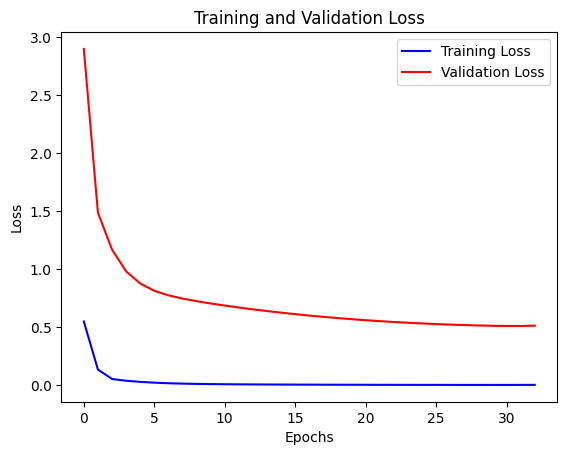

In [23]:
def visualize_loss(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

visualize_loss(history, 'Training and Validation Loss')

In [24]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


In [25]:
prediction = model.predict(dataset_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


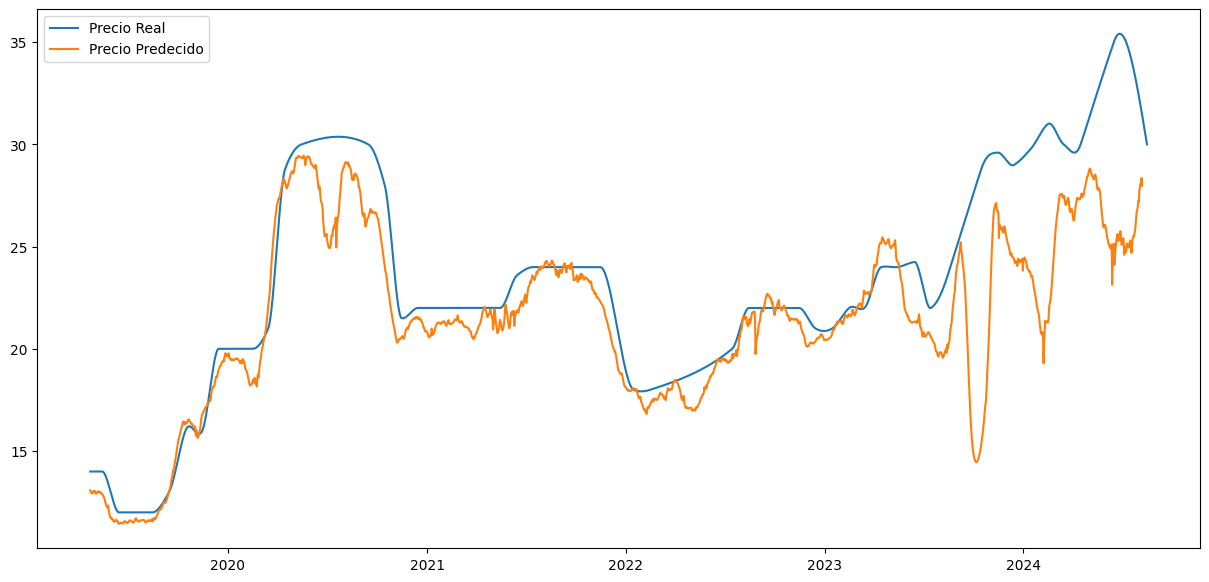

In [26]:
predictions = prediction.flatten()
count_pred = len(predictions)

#(data + 10.05598903566464) * 4.654588743043078

plt.figure(figsize=(15,7))
plt.plot(test_data['price'].index, test_data['price'] * 4.578850218807721 + 10.257168845442097, label = 'Precio Real')
plt.plot(test_data.iloc[:count_pred].index, predictions * 4.578850218807721 + 10.257168845442097, label = 'Precio Predecido')
plt.legend()

In [35]:
Val_Loss = round(history.history['val_loss'][-1], 2)
model.save(f'models/simple_1_{epochs}_{learning_rate}_{sequence_length}_{Val_Loss}.keras')

with open(f'models/simple_1_{epochs}_{learning_rate}_{sequence_length}_{Val_Loss}.txt', 'w') as cols_file:
    cols_file.write(f'For model simple_1_{epochs}_{learning_rate}_{sequence_length}_{Val_Loss} \n')
    cols_file.write(f'With Params: epochs {epochs}, learning rate {learning_rate}, sequence lenght {sequence_length} \n')
    cols_file.write(f'Has losses: Loss {history.history['loss'][-1]}, Validation Loss {Val_Loss} \n')
    cols_file.write(str(features.columns.values))